In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.cluster import KMeans,DBSCAN
from scipy import stats
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

In [67]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar.gz -P data/10x_donor3/


--2023-07-05 10:00:36--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.99.236, 188.114.98.236, 2a06:98c1:3123:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.99.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 270871692 (258M) [application/x-tar]
Saving to: ‘data/10x_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar.gz’

vdj_v1_hs_aggregate  89%[================>   ] 230.79M   125KB/s    in 6m 45s  

2023-07-05 10:07:22 (583 KB/s) - Connection closed at byte 242005800. Retrying.

--2023-07-05 10:07:23--  (try: 2)  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar.gz
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.99.236|:443... connected.
HTTP request sent, awaiti

In [68]:
!wget https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor3/vdj_v1_hs_aggregated_donor3_all_contig_annotations.csv -P data/10x_donor3/

--2023-07-05 10:07:29--  https://cf.10xgenomics.com/samples/cell-vdj/3.0.2/vdj_v1_hs_aggregated_donor3/vdj_v1_hs_aggregated_donor3_all_contig_annotations.csv
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 188.114.98.236, 188.114.99.236, 2a06:98c1:3122:e000::c, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|188.114.98.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73908094 (70M) [text/csv]
Saving to: ‘data/10x_donor3/vdj_v1_hs_aggregated_donor3_all_contig_annotations.csv’

vdj_v1_hs_aggregate 100%[===================>]  70.48M  9.53MB/s    in 17s     

2023-07-05 10:07:48 (4.07 MB/s) - ‘data/10x_donor3/vdj_v1_hs_aggregated_donor3_all_contig_annotations.csv’ saved [73908094/73908094]



In [69]:
!gunzip data/10x_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar.gz

In [70]:
!tar -xvf data/10x_donor3/vdj_v1_hs_aggregated_donor3_filtered_feature_bc_matrix.tar -C data/10x_donor3/

filtered_feature_bc_matrix/
filtered_feature_bc_matrix/features.tsv.gz
filtered_feature_bc_matrix/barcodes.tsv.gz
filtered_feature_bc_matrix/matrix.mtx.gz


In [71]:
!gunzip data/10x_donor3/filtered_feature_bc_matrix/matrix.mtx.gz
!gunzip data/10x_donor3/filtered_feature_bc_matrix/features.tsv.gz
!gunzip data/10x_donor3/filtered_feature_bc_matrix/barcodes.tsv.gz

In [2]:
import tcr_emb_prep
import data_processing

In [3]:
barcodes = data_processing.read_barcodes('data/10x_donor3/filtered_feature_bc_matrix/barcodes.tsv')

features = data_processing.read_features('data/10x_donor3/filtered_feature_bc_matrix/features.tsv')

matrix = data_processing.read_matrix('data/10x_donor3/filtered_feature_bc_matrix/matrix.mtx')

matrix_2 = data_processing.merge_matrix(matrix,barcodes,features)
matrix_2 = data_processing.get_value_matrix(matrix_2)

matrix_3 = matrix_2[matrix_2['type']=='Antibody Capture']
matrix_3 = matrix_3[matrix_3['value_type']!='TotalSeqC']

matrix_t = data_processing.get_tetramer_matrix(matrix_3)
matrix_t


,barcode,value,tetramer,count
0,TTTGTCATCTCTAAGG-12,AAKGRGAAL,AAKGRGAAL,69912747
1,TTTGTCATCTCTAAGG-12,KLGGALQAK,AAKGRGAAL,15
2,TTTGTCATCTCTAAGG-12,RLRAEAQVK,AAKGRGAAL,5
3,TTTGTCATCTCTAAGG-12,LLDFVRFMGV,AAKGRGAAL,2
4,TTTGTCATCTCTAAGG-12,RMFPNAPYL,AAKGRGAAL,2
...,...,...,...,...
299097,CGAGCACAGGTACTCT-12,RIAAWMATY,RLRAEAQVK,2
299098,CGAGCACAGGTACTCT-12,LLFGYPVYV,RLRAEAQVK,1
299099,CGAGCACAGGTACTCT-12,SLFNTVATL,RLRAEAQVK,1
299100,CGAGCACAGGTACTCT-12,AYSSAGASI,RLRAEAQVK,1


In [4]:
barcode_tetramer = data_processing.get_barcode_tetramer(matrix_3)
barcode_tetramer

/home/yuliajk/projects/tcr_emb/data_processing.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tetramers['tetramer'] = tetramers['value']


,barcode,tetramer,count
0,TTTGTCATCTCTAAGG-12,AAKGRGAAL,69912747
32126152,CCCTCCTAGTCAAGGC-2,IVTDFSVIK,1053
32172886,CGAGAAGCACCGAAAG-4,AVFDRKSDAK,678
32179088,ACGATACCAGTTCCCT-6,AVFDRKSDAK,614
47365861,CTCGGGACAGTCAGCC-7,GILGFVFTL,296
...,...,...,...
32208006,CGGAGCTGTTATCACG-3,QYDPVAALF,1
32206197,GAGCAGAAGTGGTCCC-5,IPSINVHHY,1
32209915,GTTCTCGGTCTGGAGA-11,QYDPVAALF,1
32209839,CATATTCGTCGAGATG-11,QYDPVAALF,1


In [33]:
data = pd.read_csv("data/10x_donor3/vdj_v1_hs_aggregated_donor3_all_contig_annotations.csv", sep = ',')
data_c_annot = data.copy()
data_c_annot = data_c_annot[data_c_annot['is_cell']==True].reset_index(drop=True)
data_c_annot = tcr_emb_prep.filter_table(data_c_annot,'TRB')
data_c = data_c_annot.copy()
data_c = data_processing.merge_anot_matrix(data_c,barcode_tetramer)
data_c = data_c.drop_duplicates(['barcode','tetramer'])
data_c.to_csv('data_scripts/data_annot_preped.txt', sep='\t', index = False)
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
0,AAACCTGAGAAACCGC-1,True,AAACCTGAGAAACCGC-1_contig_2,True,663,TRB,TRBV29-1,None,TRBJ1-2,TRBC1,True,True,CSVDLEANYGYTF,TGCAGCGTTGACCTCGAAGCTAACTATGGCTACACCTTC,5708,6,clonotype1,clonotype1_consensus_2,KLGGALQAK,38
1,AAACCTGAGATGTTAG-12,True,AAACCTGAGATGTTAG-12_contig_3,True,735,TRB,TRBV7-9,TRBD1,TRBJ2-2,TRBC2,True,True,CASSPQDRAFAGELFF,TGTGCCAGCAGCCCTCAAGACAGGGCGTTTGCTGGGGAGCTGTTTTTT,16390,29,clonotype1443,clonotype1443_consensus_2,GLCTLVAML,1
2,AAACCTGAGCAAATCA-10,True,AAACCTGAGCAAATCA-10_contig_1,True,501,TRB,TRBV7-8,None,TRBJ1-2,TRBC1,True,True,CASSLGQDGYTF,TGTGCCAGCAGCTTAGGTCAGGATGGCTACACCTTC,7397,10,clonotype5,clonotype5_consensus_1,KLGGALQAK,4
3,AAACCTGAGCGCTCCA-4,True,AAACCTGAGCGCTCCA-4_contig_1,True,556,TRB,TRBV12-4,None,TRBJ2-3,TRBC2,True,True,CASSPMDTQYF,TGTGCCAGCAGCCCAATGGATACGCAGTATTTT,13166,10,clonotype4,clonotype4_consensus_2,KLGGALQAK,34
4,AAACCTGAGCGTAGTG-3,True,AAACCTGAGCGTAGTG-3_contig_3,True,561,TRB,TRBV3-1,None,TRBJ2-3,TRBC2,True,True,CASSQDRVLGDTQYF,TGTGCCAGCAGCCAAGATCGGGTTTTGGGAGATACGCAGTATTTT,6870,6,clonotype1444,clonotype1444_consensus_2,KLGGALQAK,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38595,TTTGTCATCTCTAAGG-12,True,TTTGTCATCTCTAAGG-12_contig_2,True,702,TRB,TRBV5-6,TRBD1,TRBJ2-3,TRBC2,True,True,CASSRDRGEDTQYF,TGTGCCAGCAGCCGGGACAGGGGGGAAGATACGCAGTATTTT,2367,5,clonotype23,clonotype23_consensus_1,AAKGRGAAL,69912747
38596,TTTGTCATCTCTGTCG-7,True,TTTGTCATCTCTGTCG-7_contig_1,True,670,TRB,TRBV19,TRBD1,TRBJ1-2,TRBC1,True,True,CASSILGALSYGYTF,TGTGCCAGTAGTATACTCGGGGCGCTTAGCTATGGCTACACCTTC,4269,6,clonotype18110,clonotype18110_consensus_1,KLGGALQAK,30
38597,TTTGTCATCTGAGGGA-4,True,TTTGTCATCTGAGGGA-4_contig_1,True,694,TRB,TRBV5-1,TRBD2,TRBJ1-2,TRBC1,True,True,CASSLGLTGLAYGYTF,TGCGCCAGCAGCTTGGGCCTCACTGGCCTTGCCTATGGCTACACCTTC,11871,7,clonotype18111,clonotype18111_consensus_2,KLGGALQAK,21
38598,TTTGTCATCTTGACGA-5,True,TTTGTCATCTTGACGA-5_contig_1,True,815,TRB,TRBV19,TRBD1,TRBJ1-2,TRBC1,True,True,CASSARTGVGYGYTF,TGTGCCAGTAGTGCGAGAACAGGGGTTGGCTATGGCTACACCTTC,2589,3,clonotype11,clonotype11_consensus_2,AVFDRKSDAK,12


In [34]:
data_c[data_c['tetramer']=='KLGGALQAK'].shape

(30212, 20)

In [43]:
#prototypes_pre = pd.read_csv('data/olga_seqs.tsv', sep = '\t', header=None)
#prototypes = prototypes_prep(prototypes_pre)
#prototypes.to_csv('data_scripts/prototypes_olga.txt', sep='\t', index = False)

In [6]:
prototypes_path = "data_scripts/prototypes_olga.txt"
prototypes=pd.read_csv(prototypes_path, sep = '\t')

In [32]:
data_c = data_c[data_c['tetramer']!='KLGGALQAK'].reset_index(drop=True)
data_c.shape

(6542, 20)

In [8]:
data_c = data_c[data_c['v_gene'].isin(list(prototypes['v']))].reset_index(drop=True)
data_c = data_c[data_c['j_gene'].isin(list(prototypes['j']))].reset_index(drop=True)
data_c

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id,tetramer,count
0,AAACCTGAGATGTTAG-12,True,AAACCTGAGATGTTAG-12_contig_3,True,735,TRB,TRBV7-9,TRBD1,TRBJ2-2,TRBC2,True,True,CASSPQDRAFAGELFF,TGTGCCAGCAGCCCTCAAGACAGGGCGTTTGCTGGGGAGCTGTTTTTT,16390,29,clonotype1443,clonotype1443_consensus_2,GLCTLVAML,1
1,AAACCTGAGCTAAGAT-11,True,AAACCTGAGCTAAGAT-11_contig_2,True,541,TRB,TRBV7-3,TRBD2,TRBJ2-3,TRBC2,True,True,CASSPRLAGGADTQYF,TGTGCCAGCAGCCCCAGACTAGCGGGGGGCGCAGATACGCAGTATTTT,6721,5,clonotype1445,clonotype1445_consensus_2,RLRAEAQVK,5
2,AAACCTGAGTCGTTTG-8,True,AAACCTGAGTCGTTTG-8_contig_1,True,573,TRB,TRBV7-9,None,TRBJ2-7,TRBC2,True,True,CASKDGISYEQYF,TGTGCCAGCAAGGACGGAATCTCCTACGAGCAGTACTTC,1233,3,clonotype7,clonotype7_consensus_2,AVFDRKSDAK,2
3,AAACCTGAGTGGCACA-12,True,AAACCTGAGTGGCACA-12_contig_1,True,572,TRB,TRBV12-5,TRBD1,TRBJ2-2,TRBC2,True,True,CASGLVYRDRRRVDSDGELFF,TGTGCTAGTGGTTTGGTCTATCGGGACAGGAGGAGGGTTGACTCTG...,6682,10,clonotype1453,clonotype1453_consensus_2,AVFDRKSDAK,5
4,AAACCTGCAACCGCCA-1,True,AAACCTGCAACCGCCA-1_contig_1,True,533,TRB,TRBV29-1,None,TRBJ1-2,TRBC1,True,True,CSVDLEANYGYTF,TGCAGCGTTGACCTCGAAGCTAACTATGGCTACACCTTC,5624,6,clonotype1,clonotype1_consensus_2,RLRAEAQVK,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,TTTGTCATCGTCTGAA-6,True,TTTGTCATCGTCTGAA-6_contig_1,True,778,TRB,TRBV7-9,TRBD1,TRBJ2-4,TRBC2,True,True,CASSPSRDREFLYIQYF,TGTGCCAGCAGCCCGTCCCGGGACAGGGAATTTTTGTACATTCAGT...,17673,20,clonotype33,clonotype33_consensus_3,AVFDRKSDAK,49
6524,TTTGTCATCTAAGCCA-12,True,TTTGTCATCTAAGCCA-12_contig_1,True,751,TRB,TRBV7-9,TRBD2,TRBJ2-1,TRBC2,True,True,CASTGTSGGPTLRDEQFF,TGTGCCAGCACCGGGACTAGCGGGGGCCCAACCTTGAGGGATGAGC...,12810,26,clonotype8,clonotype8_consensus_1,CYTWNQMNL,5
6525,TTTGTCATCTCTAAGG-12,True,TTTGTCATCTCTAAGG-12_contig_2,True,702,TRB,TRBV5-6,TRBD1,TRBJ2-3,TRBC2,True,True,CASSRDRGEDTQYF,TGTGCCAGCAGCCGGGACAGGGGGGAAGATACGCAGTATTTT,2367,5,clonotype23,clonotype23_consensus_1,AAKGRGAAL,69912747
6526,TTTGTCATCTTGACGA-5,True,TTTGTCATCTTGACGA-5_contig_1,True,815,TRB,TRBV19,TRBD1,TRBJ1-2,TRBC1,True,True,CASSARTGVGYGYTF,TGTGCCAGTAGTGCGAGAACAGGGGTTGGCTATGGCTACACCTTC,2589,3,clonotype11,clonotype11_consensus_2,AVFDRKSDAK,12


In [9]:
data_c_mir = tcr_emb_prep.columns_prep(data_c)
data_c_mir

,contig_id,length,v,j,cdr3aa,reads,umis,count,DStart,DEnd,VEnd,JStart,freq,cdr3nt,subset
0,AAACCTGAGATGTTAG-12_contig_3,735,TRBV7-9,TRBJ2-2,CASSPQDRAFAGELFF,16390,29,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCCTCAAGATCGTGCTTTTGCTGGTGAATTATTTTTT,.
1,AAACCTGAGCTAAGAT-11_contig_2,541,TRBV7-3,TRBJ2-3,CASSPRLAGGADTQYF,6721,5,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCCTCGTTTAGCTGGTGGTGCTGATACTCAATATTTT,.
2,AAACCTGAGTCGTTTG-8_contig_1,573,TRBV7-9,TRBJ2-7,CASKDGISYEQYF,1233,3,1,-1,-1,-1,-1,-1,TGTGCTTCTAAAGATGGTATTTCTTATGAACAATATTTT,.
3,AAACCTGAGTGGCACA-12_contig_1,572,TRBV12-5,TRBJ2-2,CASGLVYRDRRRVDSDGELFF,6682,10,1,-1,-1,-1,-1,-1,TGTGCTTCTGGTTTAGTTTATCGTGATCGTCGTCGTGTTGATTCTG...,.
4,AAACCTGCAACCGCCA-1_contig_1,533,TRBV29-1,TRBJ1-2,CSVDLEANYGYTF,5624,6,1,-1,-1,-1,-1,-1,TGTTCTGTTGATTTAGAAGCTAATTATGGTTATACTTTT,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,TTTGTCATCGTCTGAA-6_contig_1,778,TRBV7-9,TRBJ2-4,CASSPSRDREFLYIQYF,17673,20,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCCTTCTCGTGATCGTGAATTTTTATATATTCAAT...,.
6524,TTTGTCATCTAAGCCA-12_contig_1,751,TRBV7-9,TRBJ2-1,CASTGTSGGPTLRDEQFF,12810,26,1,-1,-1,-1,-1,-1,TGTGCTTCTACTGGTACTTCTGGTGGTCCTACTTTACGTGATGAAC...,.
6525,TTTGTCATCTCTAAGG-12_contig_2,702,TRBV5-6,TRBJ2-3,CASSRDRGEDTQYF,2367,5,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTCGTGATCGTGGTGAAGATACTCAATATTTT,.
6526,TTTGTCATCTTGACGA-5_contig_1,815,TRBV19,TRBJ1-2,CASSARTGVGYGYTF,2589,3,1,-1,-1,-1,-1,-1,TGTGCTTCTTCTGCTCGTACTGGTGTTGGTTATGGTTATACTTTT,.


In [10]:
#temp file
file_date = 'd3_040723'
file_path = 'data_scripts/10x_trb_' + file_date +'.txt'
data_c_mir.to_csv(file_path, sep='\t', index = False)

In [11]:

mir_path = "mir-1.0-SNAPSHOT.jar"
species = "Human"
chain = "TRB"
prototypes_path = "data_scripts/prototypes_olga.txt"
input_data_path = 'data_scripts/10x_trb_' + file_date +'.txt'
output_path = "data_scripts/10x_trb_" + file_date + "_"


In [12]:
command = "java -Xmx100G -cp " + mir_path + " com.antigenomics.mir.scripts.Examples cdr3aavj-pairwise-dist " + "-S " + species + " -G " + chain + " -F VDJtools " + "-I " + prototypes_path + " " + input_data_path + " -O " + output_path
os.system(command)

0

In [13]:
prototypes = pd.read_csv(prototypes_path, sep='\t')
data_c_mir = pd.read_csv(input_data_path, sep='\t')
data_c_b_dists_raw = pd.read_csv(str(output_path + '.dist.txt'), sep = '\t')
data_c_b_dists_raw

,id1,id2,v.score,j.score,cdr3.score
0,1,1,507.0,51.0,32.0
1,1,2,327.0,44.0,16.0
2,1,3,507.0,47.0,13.0
3,1,4,283.0,51.0,21.0
4,1,5,146.0,45.0,-2.0
...,...,...,...,...,...
19583995,3000,6524,150.0,40.0,14.0
19583996,3000,6525,150.0,51.0,19.0
19583997,3000,6526,138.0,44.0,22.0
19583998,3000,6527,272.0,45.0,5.0


In [14]:
data_c_b_dists_raw['cdr3_idx'] = 'cdr3_' + data_c_b_dists_raw["id1"].astype(str)
data_c_b_dists_raw['v_idx'] = 'v_' + data_c_b_dists_raw["id1"].astype(str)
data_c_b_dists_raw['j_idx'] = 'j_' + data_c_b_dists_raw["id1"].astype(str)
data_c_b_dist = pd.concat([data_c_b_dists_raw.pivot(index='id2',columns='cdr3_idx',values='cdr3.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id2',columns='v_idx',values='v.score').reset_index(),
                     data_c_b_dists_raw.pivot(index='id2',columns='j_idx',values='j.score').reset_index()], axis=1)
data_c_b_dist = data_c_b_dist.drop('id2',axis=1)
data_c_b_dist = data_c_b_dist.set_index(data_c['barcode'],drop = True)

In [15]:
pca_df, pca_model = data_processing.pca(data_c_b_dist,50)
pca_df_data = pca_df.copy()
pca_df_data['barcode']=data_c_b_dist.index
pca_df_data=pca_df_data.merge(data_c[['barcode','tetramer']], on='barcode')
pca_df_data= pca_df_data.groupby(['barcode']).first().reset_index()
pca_df_data


,barcode,0,1,2,3,4,5,6,7,8,...,41,42,43,44,45,46,47,48,49,tetramer
0,AAACCTGAGATGTTAG-12,0.693683,-19.158468,-57.600074,-21.629376,-0.494342,9.617741,-28.955870,-0.195892,14.364624,...,-3.126370,0.723062,-3.424976,1.968287,2.718369,1.038571,0.212848,-3.343624,-0.833609,GLCTLVAML
1,AAACCTGAGCTAAGAT-11,-53.215229,-38.253889,0.855178,21.834715,-4.819863,17.381001,-25.038740,-1.482790,-9.842541,...,0.820367,2.671891,0.380747,5.325446,2.013124,4.796612,-3.669661,5.324325,14.863194,RLRAEAQVK
2,AAACCTGAGTCGTTTG-8,-49.132259,-43.951664,15.779364,-1.361203,-25.200523,-22.667640,-0.421789,-5.157326,-8.387468,...,5.026398,3.744058,-1.950147,0.405877,-2.436107,-0.745923,0.811495,-3.206546,-0.006945,AVFDRKSDAK
3,AAACCTGAGTGGCACA-12,23.578964,-15.423742,-41.128522,-25.613124,6.893991,11.865706,-37.703352,1.595944,17.029115,...,3.761160,-0.946090,4.290947,-2.348361,-2.154760,-3.507026,-1.328216,-0.538940,0.139770,AVFDRKSDAK
4,AAACCTGCAACCGCCA-1,104.025560,-17.230698,30.251476,1.248032,-8.249180,-1.190955,-1.406837,1.310227,5.552041,...,-0.907759,-0.065608,-0.563579,0.137115,0.271475,0.426041,0.187479,-0.093131,0.035386,RLRAEAQVK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,TTTGTCATCGTCTGAA-6,-15.356751,-33.577457,-10.959540,29.502429,-3.108826,2.377667,-19.722579,-5.246077,2.536262,...,-4.615702,-3.555666,0.298230,-3.137650,4.705112,-3.838015,-1.251675,4.574798,3.071547,AVFDRKSDAK
6524,TTTGTCATCTAAGCCA-12,-47.174945,-31.305904,-8.586844,-12.729199,-7.783179,-5.644619,-16.342041,-12.646995,22.412794,...,1.970108,-5.776996,-5.859201,-4.108199,0.365574,-2.609156,0.974106,3.393537,-3.958795,CYTWNQMNL
6525,TTTGTCATCTCTAAGG-12,-57.205777,-24.002042,-3.763609,27.120320,2.006330,21.248794,25.420396,38.321733,10.874805,...,3.736199,1.221640,2.564808,-1.460338,2.179057,-2.312523,-6.387397,-5.241732,-1.912512,AAKGRGAAL
6526,TTTGTCATCTTGACGA-5,52.763713,37.611050,-4.747478,20.422303,-43.465324,-1.701767,17.533108,-4.232084,-3.963461,...,1.003085,0.561617,1.614599,1.418087,4.817585,4.585932,4.114241,3.749602,3.239158,AVFDRKSDAK


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, '1 component')

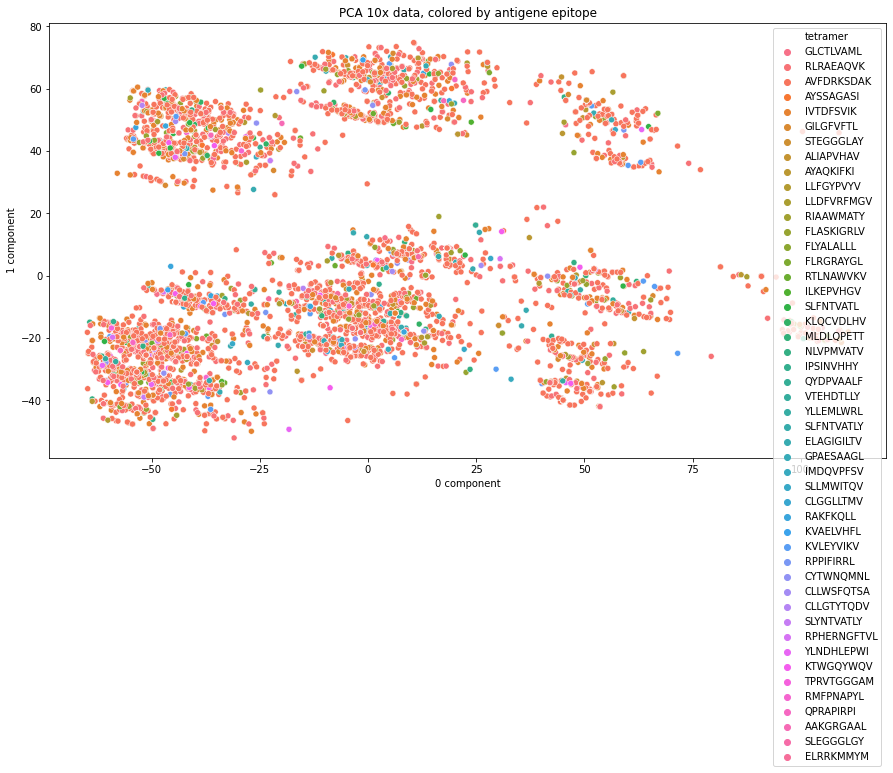

In [16]:
pc1 = 0
pc2 = 1
plt.figure(figsize=(15,8))
ax = sns.scatterplot(pc1, pc2, data=pca_df_data, hue='tetramer')
ax.set_title("PCA 10x data, colored by antigene epitope")
ax.set_xlabel(str(pc1)+" component")
ax.set_ylabel(str(pc2)+" component")

In [17]:
X_embedded = data_processing.tsne(pca_df,2,0,50)
tsne_df = pd.DataFrame(data = X_embedded, columns = ['DM1', 'DM2'])


tsne_df_data = tsne_df.copy()
#tsne_df_data['cdr3']=data_c_b_dist.index
tsne_df_data['barcode']=data_c_b_dist.index

tsne_df_data=tsne_df_data.merge(data_c[['barcode','tetramer','cdr3']], on='barcode')
tsne_df_data= tsne_df_data.groupby(['barcode']).first().reset_index()
tsne_df_data

,barcode,DM1,DM2,tetramer,cdr3
0,AAACCTGAGATGTTAG-12,-2.787218,-17.709021,GLCTLVAML,CASSPQDRAFAGELFF
1,AAACCTGAGCTAAGAT-11,-39.825668,-36.110615,RLRAEAQVK,CASSPRLAGGADTQYF
2,AAACCTGAGTCGTTTG-8,-45.424526,-68.200485,AVFDRKSDAK,CASKDGISYEQYF
3,AAACCTGAGTGGCACA-12,0.383884,-20.364441,AVFDRKSDAK,CASGLVYRDRRRVDSDGELFF
4,AAACCTGCAACCGCCA-1,101.062927,-8.675363,RLRAEAQVK,CSVDLEANYGYTF
...,...,...,...,...,...
6523,TTTGTCATCGTCTGAA-6,-22.431671,-30.066235,AVFDRKSDAK,CASSPSRDREFLYIQYF
6524,TTTGTCATCTAAGCCA-12,-60.368340,-37.221725,CYTWNQMNL,CASTGTSGGPTLRDEQFF
6525,TTTGTCATCTCTAAGG-12,-71.183205,-4.190854,AAKGRGAAL,CASSRDRGEDTQYF
6526,TTTGTCATCTTGACGA-5,56.630856,38.863255,AVFDRKSDAK,CASSARTGVGYGYTF


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


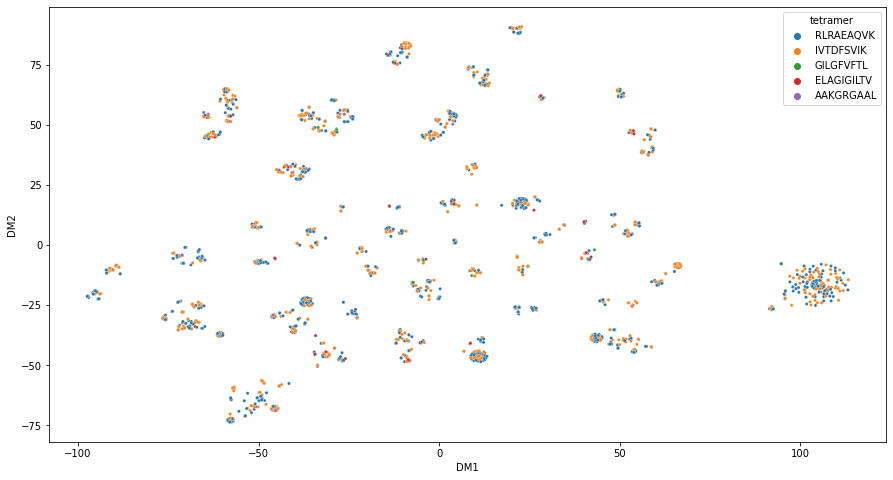

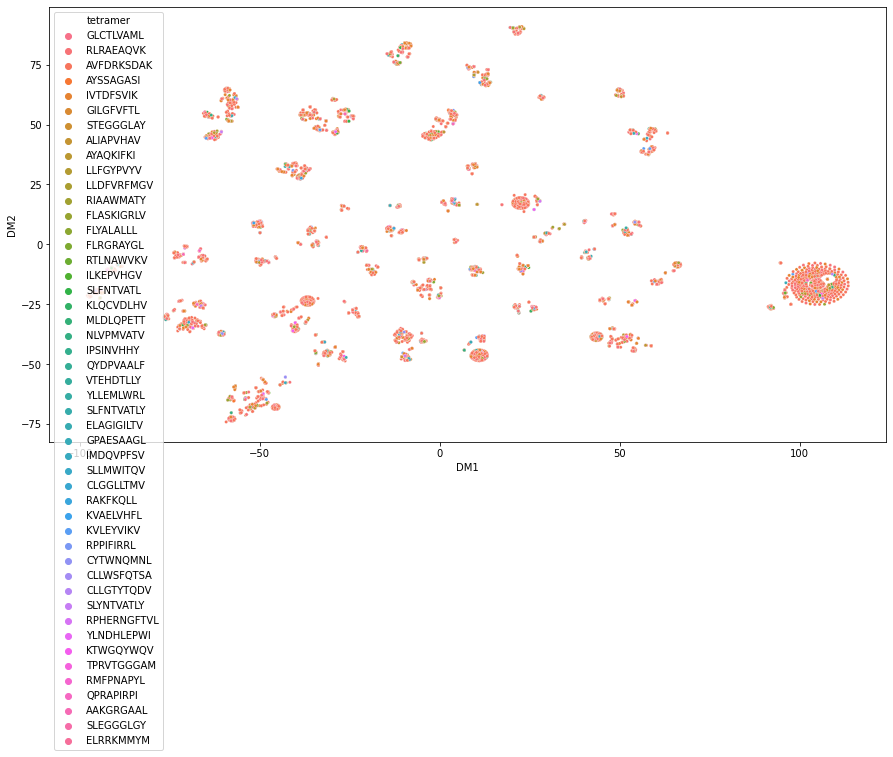

In [18]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data[tsne_df_data['tetramer'].isin(['KLGGALQAK','AAKGRGAAL','GILGFVFTL','ELAGIGILTV','RLRAEAQVK','IVTDFSVIK'])], hue='tetramer',s=10)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=tsne_df_data, hue='tetramer',s=10)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")

## Clustering

In [19]:
kmeans = KMeans(n_clusters=80, random_state=0).fit(pca_df)

In [20]:
clusters = pd.DataFrame(kmeans.labels_, columns= ['cluster'])
df_kmeans = pd.concat([tsne_df_data, clusters], axis = 1)
df_kmeans

,barcode,DM1,DM2,tetramer,cdr3,cluster
0,AAACCTGAGATGTTAG-12,-2.787218,-17.709021,GLCTLVAML,CASSPQDRAFAGELFF,62
1,AAACCTGAGCTAAGAT-11,-39.825668,-36.110615,RLRAEAQVK,CASSPRLAGGADTQYF,6
2,AAACCTGAGTCGTTTG-8,-45.424526,-68.200485,AVFDRKSDAK,CASKDGISYEQYF,79
3,AAACCTGAGTGGCACA-12,0.383884,-20.364441,AVFDRKSDAK,CASGLVYRDRRRVDSDGELFF,4
4,AAACCTGCAACCGCCA-1,101.062927,-8.675363,RLRAEAQVK,CSVDLEANYGYTF,2
...,...,...,...,...,...,...
6523,TTTGTCATCGTCTGAA-6,-22.431671,-30.066235,AVFDRKSDAK,CASSPSRDREFLYIQYF,58
6524,TTTGTCATCTAAGCCA-12,-60.368340,-37.221725,CYTWNQMNL,CASTGTSGGPTLRDEQFF,13
6525,TTTGTCATCTCTAAGG-12,-71.183205,-4.190854,AAKGRGAAL,CASSRDRGEDTQYF,31
6526,TTTGTCATCTTGACGA-5,56.630856,38.863255,AVFDRKSDAK,CASSARTGVGYGYTF,49


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


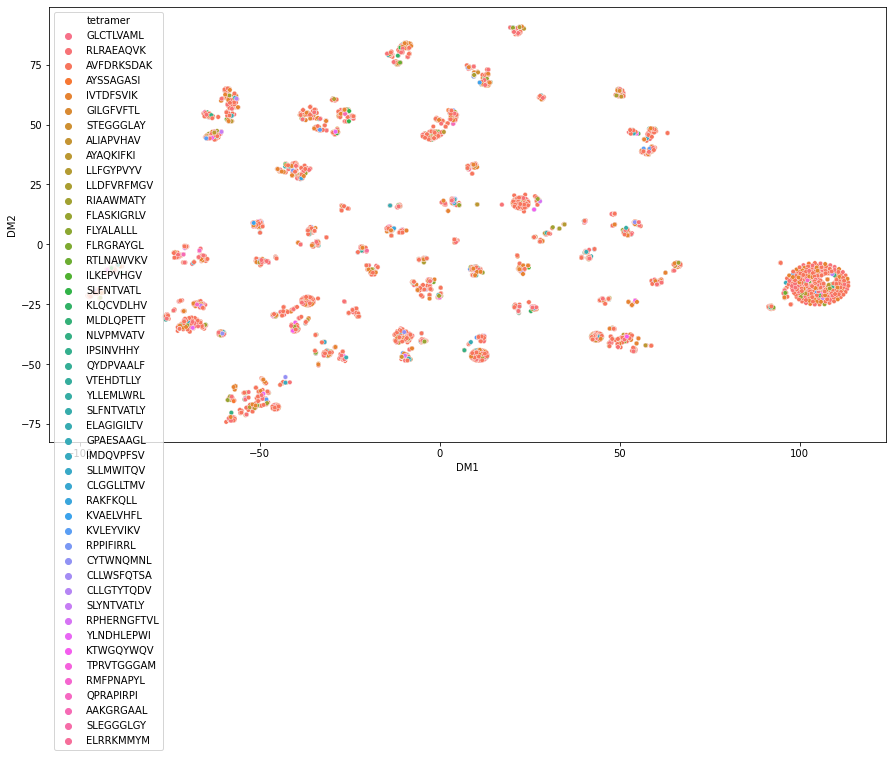

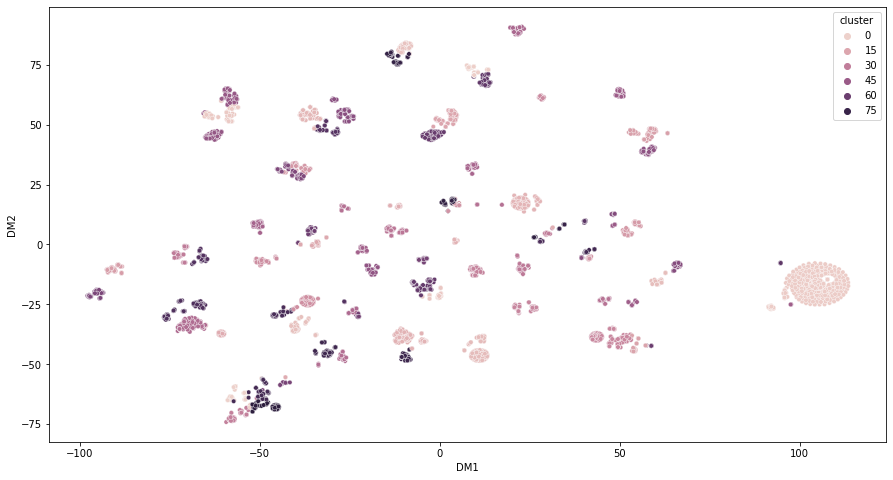

In [21]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='tetramer',s=20)
#ax = sns.scatterplot('DM1', 'DM2', data=tsne_df,s=10)
#ax.text(x=0.5, y=1.1, s='TSNE of VDJdb 10x data after PCA, colored by cell.subset', fontsize=12, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
#ax.text(x=0.5, y=1.05, s='TCRemb', fontsize=10, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
#ax.set_title("TSNE of VDJdb 10x data after PCA, colored by j segment")
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='cluster',s=20)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


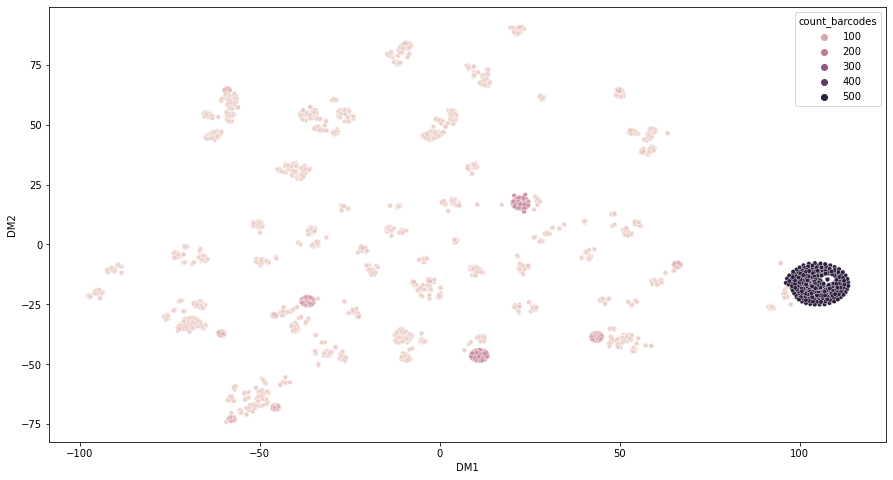

In [22]:
df_kmeans['count_barcodes'] = df_kmeans.groupby('cdr3')['barcode'].transform("size")
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans, hue='count_barcodes',s=20)


In [23]:
#binominal test
binom_df = df_kmeans.copy()
binom_df['total_cluster'] = binom_df.groupby('cluster')['cluster'].transform('count')
binom_df['total_epi'] = binom_df.groupby('tetramer')['tetramer'].transform('count')
binom_df['count_mached'] = binom_df.groupby(['tetramer','cluster'])['tetramer'].transform('count')
binom_df['fraction_mached'] = binom_df['count_mached']/binom_df['total_cluster']
binom_df['fraction_mached_e'] = binom_df['total_epi']/len(binom_df.index)
binom_df['p_value'] = binom_df.apply(lambda row: stats.binom_test(row['count_mached'], n=row['total_cluster'], p=row['fraction_mached_e'], alternative='greater'),axis=1)
binom_df = binom_df[binom_df['fraction_mached']>binom_df['fraction_mached_e']]
binom_df_v = binom_df[['tetramer','cluster','total_cluster','total_epi','count_mached','fraction_mached','fraction_mached_e','p_value']].drop_duplicates().sort_values('p_value')
#binom_df_v.to_csv('data_scripts/emb_binom_df.txt',sep='\t', index = False)
binom_df_cluster = binom_df_v.copy()
binom_df_cluster = binom_df_cluster.sort_values(['fraction_mached'],ascending=False)
binom_df_cluster = binom_df_cluster.drop_duplicates('cluster',keep='first')
binom_df_cluster

,tetramer,cluster,total_cluster,total_epi,count_mached,fraction_mached,fraction_mached_e,p_value
32,AVFDRKSDAK,17,109,3391,70,0.642202,0.519455,0.006468
72,AVFDRKSDAK,38,39,3391,25,0.641026,0.519455,0.086353
55,AVFDRKSDAK,10,175,3391,112,0.640000,0.519455,0.000850
183,AVFDRKSDAK,23,128,3391,80,0.625000,0.519455,0.010356
845,AVFDRKSDAK,64,21,3391,13,0.619048,0.519455,0.244485
...,...,...,...,...,...,...,...,...
1891,RTLNAWVKV,65,25,24,1,0.040000,0.003676,0.087969
5566,IMDQVPFSV,69,27,10,1,0.037037,0.001532,0.040547
1176,FLASKIGRLV,47,82,81,3,0.036585,0.012408,0.082388
1860,RAKFKQLL,14,64,18,2,0.031250,0.002757,0.013686


In [24]:
binom_df_cluster.head(20)

,tetramer,cluster,total_cluster,total_epi,count_mached,fraction_mached,fraction_mached_e,p_value
32,AVFDRKSDAK,17,109,3391,70,0.642202,0.519455,0.006468
72,AVFDRKSDAK,38,39,3391,25,0.641026,0.519455,0.086353
55,AVFDRKSDAK,10,175,3391,112,0.640000,0.519455,0.000850
183,AVFDRKSDAK,23,128,3391,80,0.625000,0.519455,0.010356
845,AVFDRKSDAK,64,21,3391,13,0.619048,0.519455,0.244485
126,AVFDRKSDAK,31,94,3391,58,0.617021,0.519455,0.036195
710,AVFDRKSDAK,60,23,3391,14,0.608696,0.519455,0.259526
343,AVFDRKSDAK,72,28,3391,17,0.607143,0.519455,0.230464
63,AVFDRKSDAK,34,55,3391,33,0.600000,0.519455,0.144338
46,AVFDRKSDAK,59,66,3391,39,0.590909,0.519455,0.149426


## Classification

In [25]:
from sklearn.model_selection import train_test_split


In [26]:
tetramers = list(tsne_df_data['tetramer'].drop_duplicates())
y_train, y_test,X_train, X_test,  = train_test_split(tsne_df_data['tetramer'],tsne_df,test_size=0.5)
y_test_curv = label_binarize(y_test, classes=tetramers)

### KNN

In [27]:
# Perform KNN
n_neighbors = 10
knn = neighbors.KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

pred = knn.predict(X_test)
y_pred_curv = label_binarize(pred, classes=tetramers)

In [28]:
n_classes = y_test_curv.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_curv[:,i],y_pred_curv[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
pd.DataFrame(roc_auc.values(),tetramers, columns = ['roc_auc']).sort_values('roc_auc',ascending=False).head(10)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


,roc_auc
IVTDFSVIK,0.506112
AVFDRKSDAK,0.500215
GLCTLVAML,0.500000
CLLWSFQTSA,0.500000
GPAESAAGL,0.500000
IMDQVPFSV,0.500000
SLLMWITQV,0.500000
CLGGLLTMV,0.500000
RAKFKQLL,0.500000
KVAELVHFL,0.500000


### SVM

In [29]:
from sklearn import svm

svc = svm.SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
y_pred_curv_svc = label_binarize(svc_pred, classes=tetramers)

In [30]:
n_classes = y_test_curv.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_curv[:,i],y_pred_curv_svc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])
pd.DataFrame(roc_auc.values(),tetramers, columns = ['roc_auc']).sort_values('roc_auc',ascending=False).head(10)

/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:951: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


,roc_auc
GLCTLVAML,0.5
CYTWNQMNL,0.5
ELAGIGILTV,0.5
GPAESAAGL,0.5
IMDQVPFSV,0.5
SLLMWITQV,0.5
CLGGLLTMV,0.5
RAKFKQLL,0.5
KVAELVHFL,0.5
KVLEYVIKV,0.5


/home/yuliajk/.conda-envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


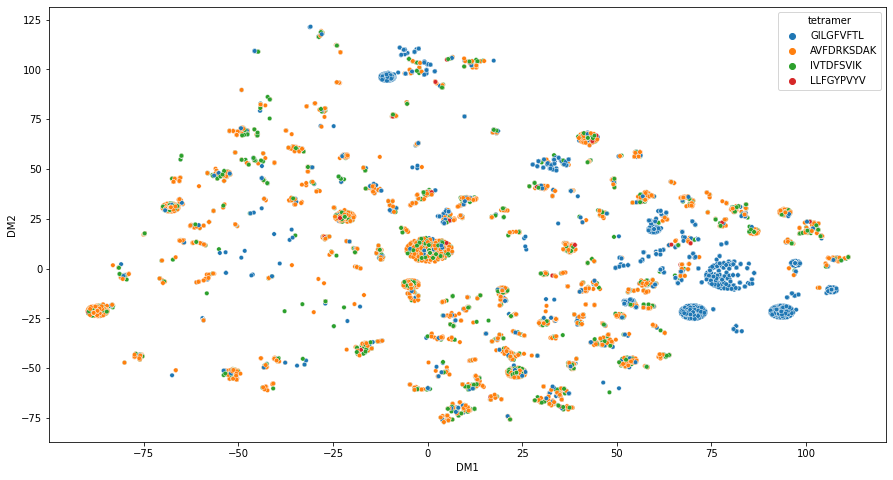

In [64]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot('DM1', 'DM2', data=df_kmeans[df_kmeans['tetramer'].isin(['LLFGYPVYV','GILGFVFTL','IVTDFSVIK','AVFDRKSDAK'])], hue='tetramer',s=20)                   
